## Feature Engineering

### Reload Cleaned Data

In [1]:
import pandas as pd

# Load the cleaned data
df = pd.read_csv('data/cleaned_data.csv', parse_dates=['Datetime'], index_col='Datetime')


In [2]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry_Room,Water_Heater_AC
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Kitchen                float64
 5   Laundry_Room           float64
 6   Water_Heater_AC        float64
dtypes: float64(7)
memory usage: 126.7 MB


In [4]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Kitchen                  0
Laundry_Room             0
Water_Heater_AC          0
dtype: int64

### Create a Total Consumption Feature

In [5]:
# Create kWh consumption (Global_active_power in kW × minutes → kWh)
df['kWh'] = df['Global_active_power'] * (1 / 60)

### Agreggating the data on daily frequency

In [6]:
# Resample to daily level
df_daily = df.resample('D').agg({
    'kWh': 'sum',
    'Voltage': 'mean',
    'Global_reactive_power': 'mean',
    'Kitchen': 'sum',
    'Laundry_Room': 'sum',
    'Water_Heater_AC': 'sum'
})

### Plot daily total kWh consumption over time

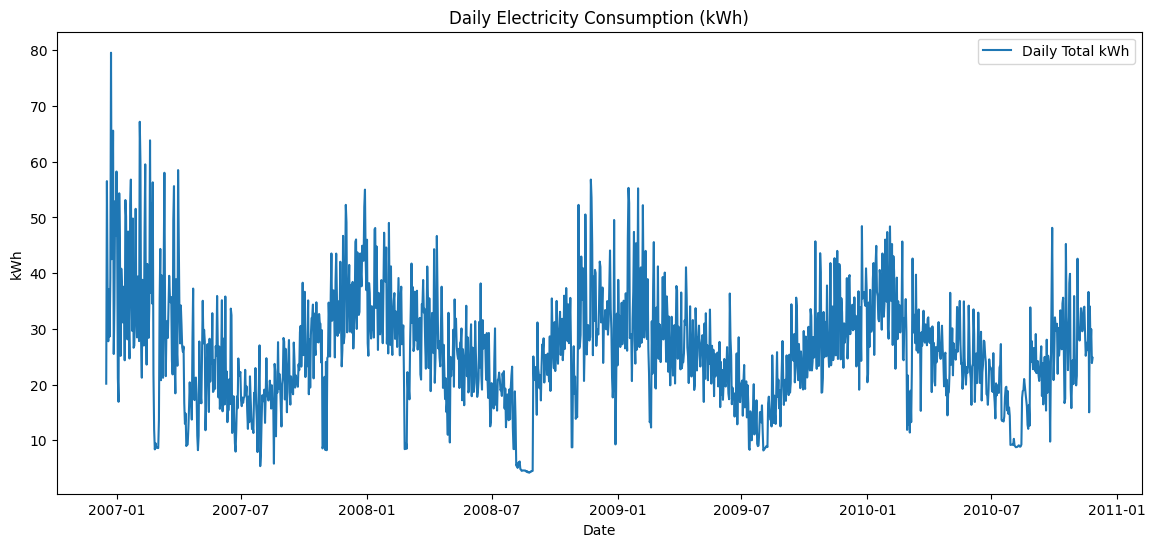

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_daily.index, df_daily['kWh'], label='Daily Total kWh')
plt.title('Daily Electricity Consumption (kWh)')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

### Add time-based features

In [8]:
df_daily['day_of_week'] = df_daily.index.dayofweek  # Monday=0, Sunday=6
df_daily['month'] = df_daily.index.month
df_daily['year'] = df_daily.index.year
df_daily['day_of_year'] = df_daily.index.dayofyear
df_daily['is_weekend'] = df_daily['day_of_week'].isin([5, 6]).astype(int)

### Add rolling statistics (7-day window)

In [9]:
df_daily['kWh_rolling_mean_7'] = df_daily['kWh'].rolling(window=7).mean()
df_daily['kWh_rolling_std_7'] = df_daily['kWh'].rolling(window=7).std()

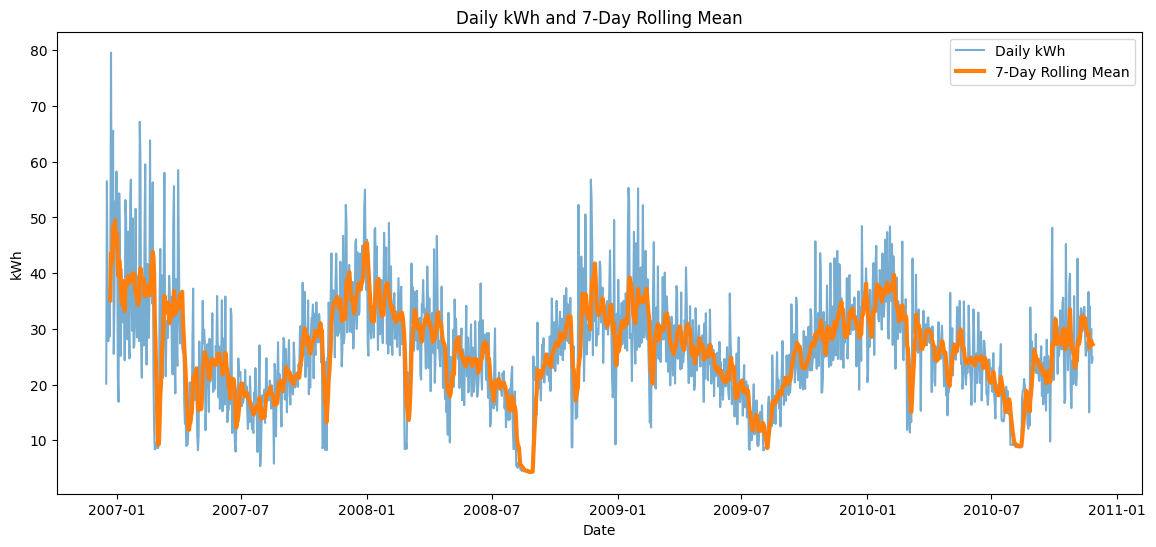

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df_daily.index, df_daily['kWh'], label='Daily kWh', alpha=0.6)
plt.plot(df_daily.index, df_daily['kWh_rolling_mean_7'], label='7-Day Rolling Mean', linewidth=3)
plt.title('Daily kWh and 7-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

**The daily usage fluctuates widely, but the rolling mean highlights a general downward trend in energy consumption around mid-2009, possibly due to reduced usage or improved efficiency, alongside recurring seasonal patterns.**

### Add lag features

In [11]:
df_daily['kWh_lag_1'] = df_daily['kWh'].shift(1)
df_daily['kWh_lag_7'] = df_daily['kWh'].shift(7)
df_daily['kWh_lag_30'] = df_daily['kWh'].shift(30)

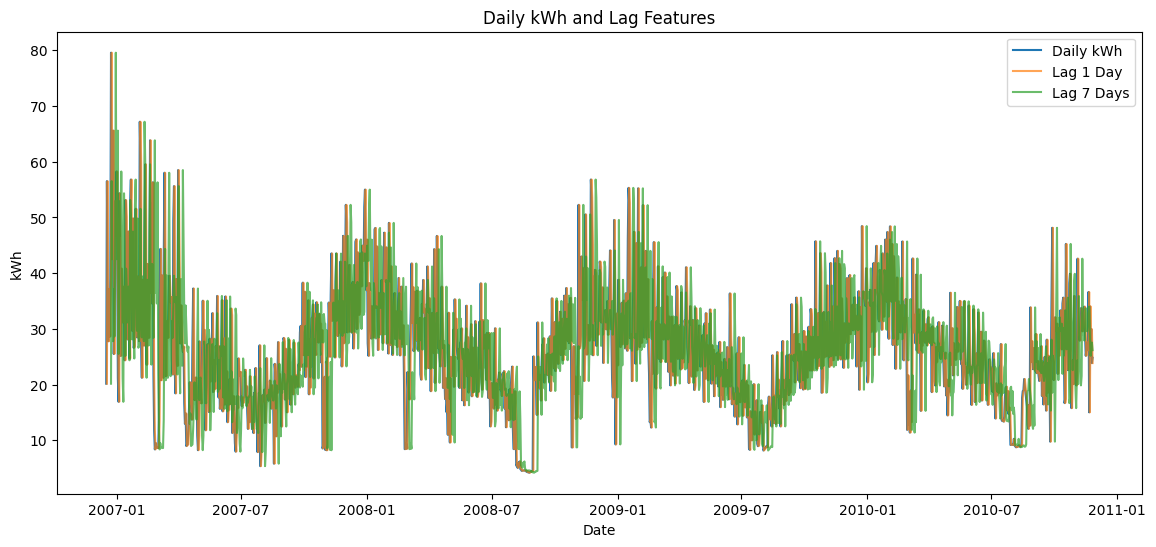

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df_daily.index, df_daily['kWh'], label='Daily kWh')
plt.plot(df_daily.index, df_daily['kWh_lag_1'], label='Lag 1 Day', alpha=0.7)
plt.plot(df_daily.index, df_daily['kWh_lag_7'], label='Lag 7 Days', alpha=0.7)
plt.title('Daily kWh and Lag Features')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

**The key insight is that the 1-day and 7-day lags closely follow the daily kWh trends, with the 7-day lag smoothing out short-term fluctuations more effectively.**

In [13]:
# Drop rows with NaN values (from rolling and lag features)
df_daily.dropna(inplace=True)

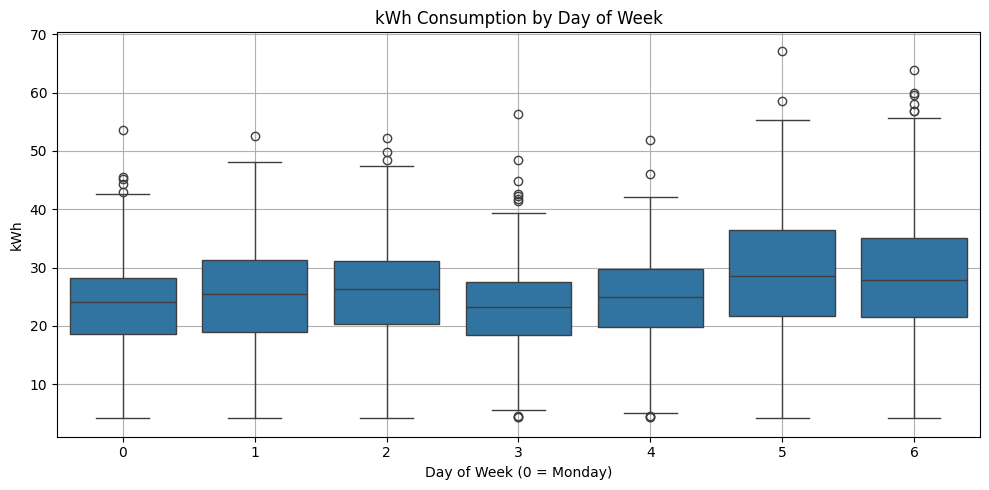

In [14]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='kWh', data=df_daily)
plt.title('kWh Consumption by Day of Week')
plt.xlabel('Day of Week (0 = Monday)')
plt.ylabel('kWh')
plt.grid(True)
plt.tight_layout()
plt.show()

**The box plot shows kWh consumption by day of the week (0 = Monday to 6 = Sunday). The key insight is that energy usage is relatively consistent across the week, with median consumption around 25-30 kWh each day. However, there are more outliers on weekends (days 5 and 6, Saturday and Sunday), indicating occasional spikes in usage, possibly due to increased activity or less consistent routines. Weekdays show tighter distributions, suggesting more predictable consumption patterns.**

In [15]:
df_daily.to_csv('data/daily_data.csv')
